In [1]:
from mmdet.apis import init_detector, inference_detector
import mmcv
import paths
import pickle
import os
from process_dataset import common

/home/tedro/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tedro/.local/lib/python3.9/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
mmcv.collect_env()

{'sys.platform': 'linux',
 'Python': '3.9.2 (default, Feb 28 2021, 17:03:44) [GCC 10.2.1 20210110]',
 'CUDA available': True,
 'GPU 0': 'NVIDIA GeForce GTX 1080 Ti',
 'CUDA_HOME': '/usr/local/cuda',
 'NVCC': 'Cuda compilation tools, release 11.8, V11.8.89',
 'GCC': 'x86_64-linux-gnu-gcc (Debian 10.2.1-6) 10.2.1 20210110',
 'PyTorch': '1.13.0+cu117',
 'PyTorch compiling details': 'PyTorch built with:\n  - GCC 9.3\n  - C++ Version: 201402\n  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications\n  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)\n  - OpenMP 201511 (a.k.a. OpenMP 4.5)\n  - LAPACK is enabled (usually provided by MKL)\n  - NNPACK is enabled\n  - CPU capability usage: AVX2\n  - CUDA Runtime 11.7\n  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_

load checkpoint from local path: /home/tedro/Desktop/d_projekty/bp/proj/working_dir/latest.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: ema_backbone_stem_conv_conv_weight, ema_backbone_stem_conv_bn_weight, ema_backbone_stem_conv_bn_bias, ema_backbone_stem_conv_bn_running_mean, ema_backbone_stem_conv_bn_running_var, ema_backbone_stem_conv_bn_num_batches_tracked, ema_backbone_stage1_0_conv_weight, ema_backbone_stage1_0_bn_weight, ema_backbone_stage1_0_bn_bias, ema_backbone_stage1_0_bn_running_mean, ema_backbone_stage1_0_bn_running_var, ema_backbone_stage1_0_bn_num_batches_tracked, ema_backbone_stage1_1_main_conv_conv_weight, ema_backbone_stage1_1_main_conv_bn_weight, ema_backbone_stage1_1_main_conv_bn_bias, ema_backbone_stage1_1_main_conv_bn_running_mean, ema_backbone_stage1_1_main_conv_bn_running_var, ema_backbone_stage1_1_main_conv_bn_num_batches_tracked, ema_backbone_stage1_1_short_conv_conv_weight, ema_backbone_stage1_1_short_conv_bn_

/home/tedro/Desktop/d_projekty/bp/mmdetection/mmdet/apis/inference.py:51: UserWarning: Class names are not saved in the checkpoint's meta data, use COCO classes by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


KeyboardInterrupt: 

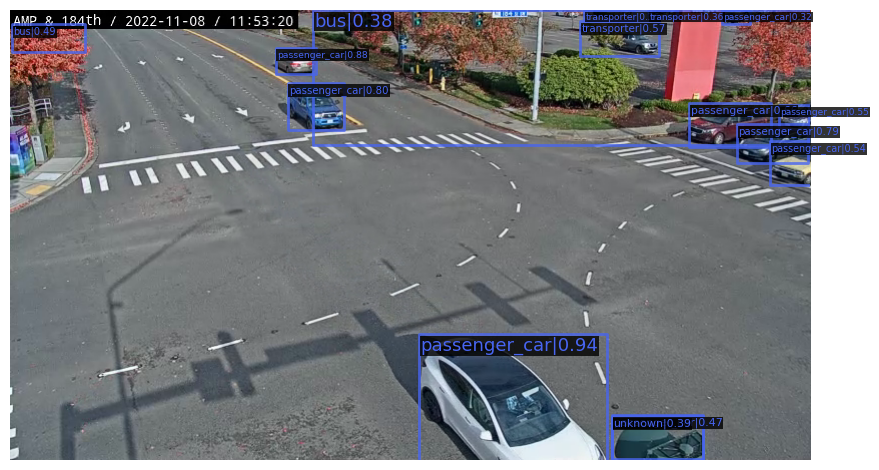

In [8]:
model = init_detector(paths.model_config_filepath, paths.last_checkpoint_filepath, device='cuda:0')
model.CLASSES = common.classes

video = mmcv.VideoReader('day_hq.mp4')

frames_dir = os.path.join(paths.working_dirpath, "tmp")
if not os.path.exists(frames_dir):
    os.mkdir(frames_dir)

counter = 0
for frame in video:
    print(counter, end="\r")

    result = inference_detector(model, frame)
    out_filepath = os.path.join(frames_dir, str(counter).zfill(6) + ".jpg")

    model.show_result(frame, result, out_file=out_filepath)

    counter += 1

In [9]:
mmcv.frames2video(frames_dir, 'video2.mp4')

[                              ] 14/8903, 77.8 task/s, elapsed: 0s, ETA:   114s

OpenCV: FFMPEG: tag 0x44495658/'XVID' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


[>>>>>>>>>>>>>>>>>>>>>>>>>>] 8903/8903, 59.1 task/s, elapsed: 151s, ETA:     0s


: 